In [81]:
pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
import os
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import numpy as np

In [83]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [84]:
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/bird_calls/eda')


from utils.utils import load_wav_16k_mono

In [85]:
capuchin_file = '../data/Parsed_Capuchinbird_Clips/XC3776-3.wav'
not_capuchin_file = '../data/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav'

wav = load_wav_16k_mono(capuchin_file)
nwav = load_wav_16k_mono(not_capuchin_file)


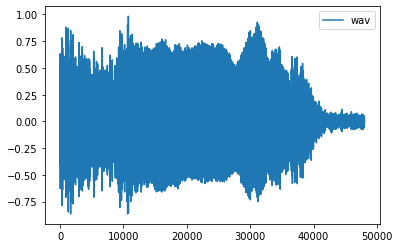

In [86]:
plt.plot(wav)
# plt.plot(nwav)
plt.legend(['wav', 'nwav'])

## Create Tensorflow Dataset

In [87]:
pos_dir = os.path.join('../data','Parsed_Capuchinbird_Clips/')
neg_dir = '../data/Parsed_Not_Capuchinbird_Clips/'

In [88]:
pos = tf.data.Dataset.list_files(pos_dir+'*.wav')
neg = tf.data.Dataset.list_files(neg_dir+'*.wav')


In [89]:
print(pos.as_numpy_iterator().next())
print(neg.as_numpy_iterator().next())

b'../data/Parsed_Capuchinbird_Clips/XC395129-0.wav'
b'../data/Parsed_Not_Capuchinbird_Clips/cicadas-noise-sound-effect-2.wav'


In [90]:
print(len(pos), len(neg))

217 593


add labels and combine negative, positive samples

In [91]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [92]:
data.shuffle(1000).as_numpy_iterator().next()

(b'../data/Parsed_Capuchinbird_Clips/XC388470-4.wav', 1.0)

## Determine Average Length of a Capuchin Call

1. Calculate wave cycle length

In [93]:
lengths = []
for file in os.listdir(pos_dir):
    tensor_wave = load_wav_16k_mono(pos_dir+file)
    lengths.append(len(tensor_wave))

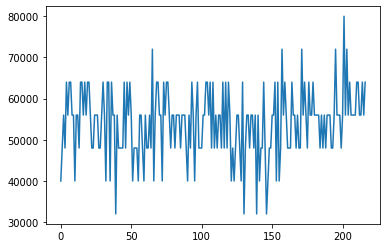

In [94]:
plt.plot(lengths)

Calculate the mean, min, max of lengths

In [95]:
print(tf.math.reduce_mean(lengths), tf.math.reduce_mean(lengths)/16000)

print(tf.math.reduce_min(lengths), tf.math.reduce_min(lengths)/16000)

print(tf.math.reduce_max(lengths), tf.math.reduce_max(lengths)/16000)

tf.Tensor(54156, shape=(), dtype=int32) tf.Tensor(3.38475, shape=(), dtype=float64)
tf.Tensor(32000, shape=(), dtype=int32) tf.Tensor(2.0, shape=(), dtype=float64)
tf.Tensor(80000, shape=(), dtype=int32) tf.Tensor(5.0, shape=(), dtype=float64)


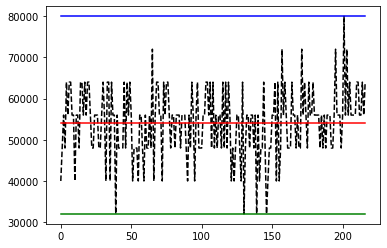

In [96]:
plt.plot(lengths, 'k--')
plt.plot([i for i in range(len(lengths))], np.ones(len(lengths))*tf.math.reduce_mean(lengths).numpy(), 'r-')
plt.plot([i for i in range(len(lengths))], np.ones(len(lengths))*tf.math.reduce_max(lengths).numpy(), 'b')
plt.plot([i for i in range(len(lengths))], np.ones(len(lengths))*tf.math.reduce_min(lengths).numpy(), 'g')


## length calc for max frames
here we're going to get max frames for an even second clip. For instance, in the examples we're using 48k frames, but this is because the mean length is ~57, which is 3.38 if divided by our output rate (16k). Thus, if we round this (3.38) to 3, then multiply by out sample_rate_out, we can intelligently select our max_rate. 

In [97]:
avg = tf.math.reduce_mean(lengths).numpy()
min_time = round(avg/16000)
print(min_time, min_time*16000)


3 48000


## Build the Preprocessing Function

In [98]:
def preprocess(file_path, label, frames =  min_time*16000):
    wav = load_wav_16k_mono(file_path)
    
    ##Select as much wav as fills frames, if len(wav) < frames, this will be less than frames and will need padding
    wav = wav[:frames]

    ##Calculate the number of zeros for padding, note if the wav >= frames, this will be empty
    
    zero_padding = tf.zeros([frames] - tf.shape(wav), dtype = tf.float32)

    ##Add zeros at the start IF the wav length < frames
    wav = tf.concat([zero_padding, wav], 0)

    #use short time fourier transform
    spectrogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)

    #Get the magnitude of the signal (los direction)
    spectrogram = tf.abs(spectrogram)

    #Adds a second dimension 
    spectrogram = tf.expand_dims(spectrogram, axis = 2)

    return spectrogram, label



### Test the function and viz spectrogram

In [99]:
filepath, label = positives.shuffle(buffer_size = 1000).as_numpy_iterator().next()

In [100]:
spectrogram, label = preprocess(filepath, label)

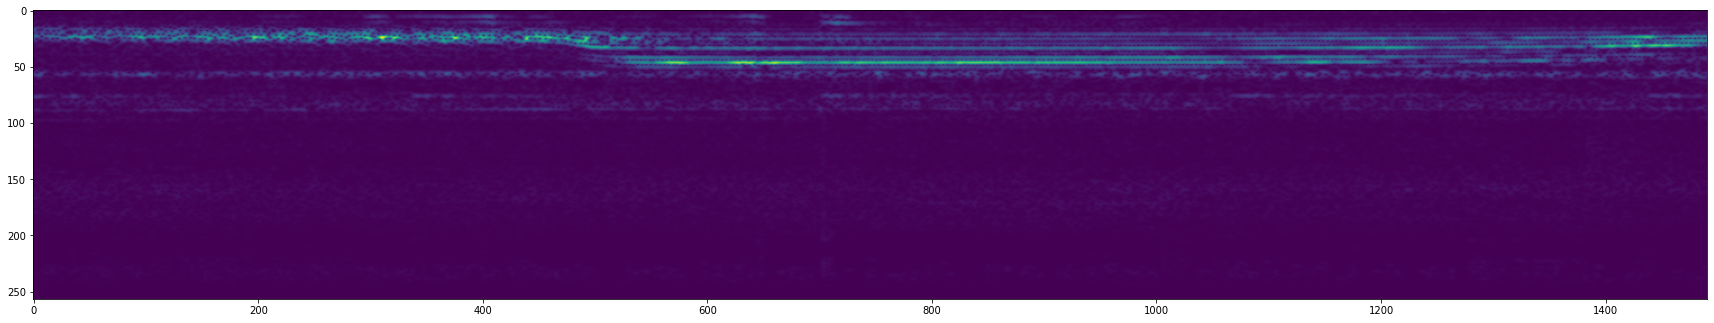

In [101]:
plt.figure(figsize=(30, 20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

## try to do the same with mels

In [102]:
tf.math.reduce_min(spectrogram), tf.math.reduce_max(spectrogram), 

(<tf.Tensor: shape=(), dtype=float32, numpy=7.450581e-09>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.7850192>)

In [103]:
def power_to_db(S, amin=1e-16, top_db=80.0):
    """Convert a power-spectrogram (magnitude squared) to decibel (dB) units.
    Computes the scaling ``10 * log10(S / max(S))`` in a numerically
    stable way.
    Based on:
    https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html
    """
    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator
    
    # Scale magnitude relative to maximum value in S. Zeros in the output 
    # correspond to positions where S == ref.
    ref = tf.reduce_max(S)

    log_spec = 10.0 * _tf_log10(tf.maximum(amin, S))
    log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref))

    log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

    return log_spec

def preprocess_to_mel_spectrogram(file_path, label, frames = 48000, ):
    wav = load_wav_16k_mono(file_path)
    
    ##Select as much wav as fills frames, if len(wav) < frames, this will be less than frames and will need padding
    wav = wav[:frames]

    ##Calculate the number of zeros for padding, note if the wav >= frames, this will be empty
    
    zero_padding = tf.zeros([frames] - tf.shape(wav), dtype = tf.float32)

    ##Add zeros at the start IF the wav length < frames
    wav = tf.concat([zero_padding, wav], 0)

    #use short time fourier transform
    spectrogram = tf.signal.stft(wav,
     frame_length = 320, ##This is fft_size
     frame_step = 32 ## this is hop_size
        ) #

    #Get the magnitude of the signal (los direction)
    spectrogram = tf.abs(spectrogram)
    
    mel_filter = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=100,
        num_spectrogram_bins = 257,
        sample_rate=frames,
        lower_edge_hertz=frames/100,
        upper_edge_hertz=frames/2,
        dtype=tf.dtypes.float32)

    mel_power_spectrogram = tf.matmul(tf.square(spectrogram), mel_filter)

    log_magnitude_mel_spectrograms = power_to_db(mel_power_spectrogram)

    log_magnitude_mel_spectrograms = tf.expand_dims(log_magnitude_mel_spectrograms, axis = 2)

    return log_magnitude_mel_spectrograms, label

In [104]:
log_mag_mel_spec, label = preprocess_to_mel_spectrogram(filepath, label)

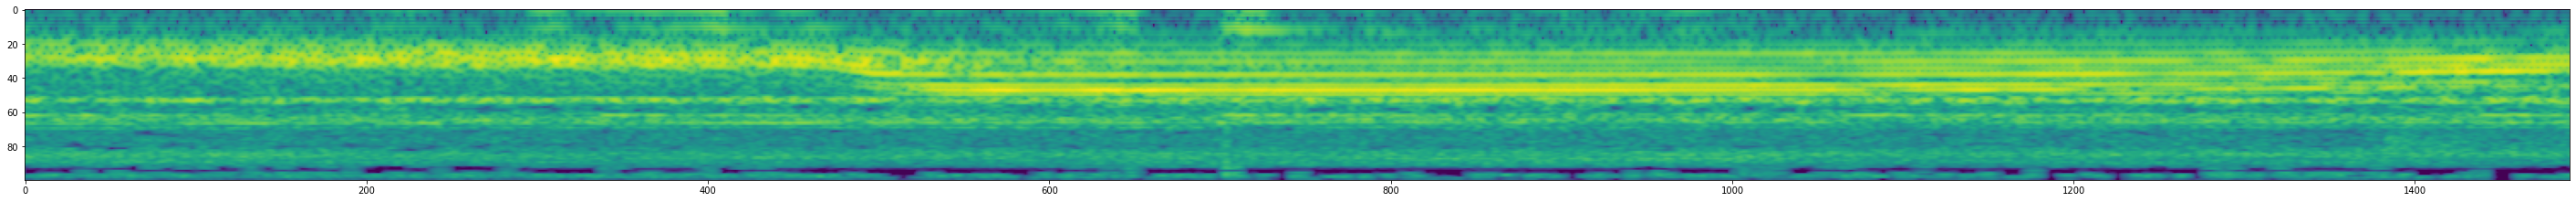

In [105]:
plt.figure(figsize=(50, 20))
plt.imshow(tf.transpose(log_mag_mel_spec)[0])
plt.show()

In [106]:
filepath_neg, label_neg = negatives.shuffle(buffer_size = 1000).as_numpy_iterator().next()
spectrogram_neg, label_neg = preprocess(filepath_neg, label_neg)
log_mag_mel_spec_neg, label_neg = preprocess_to_mel_spectrogram(filepath_neg, label_neg)


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

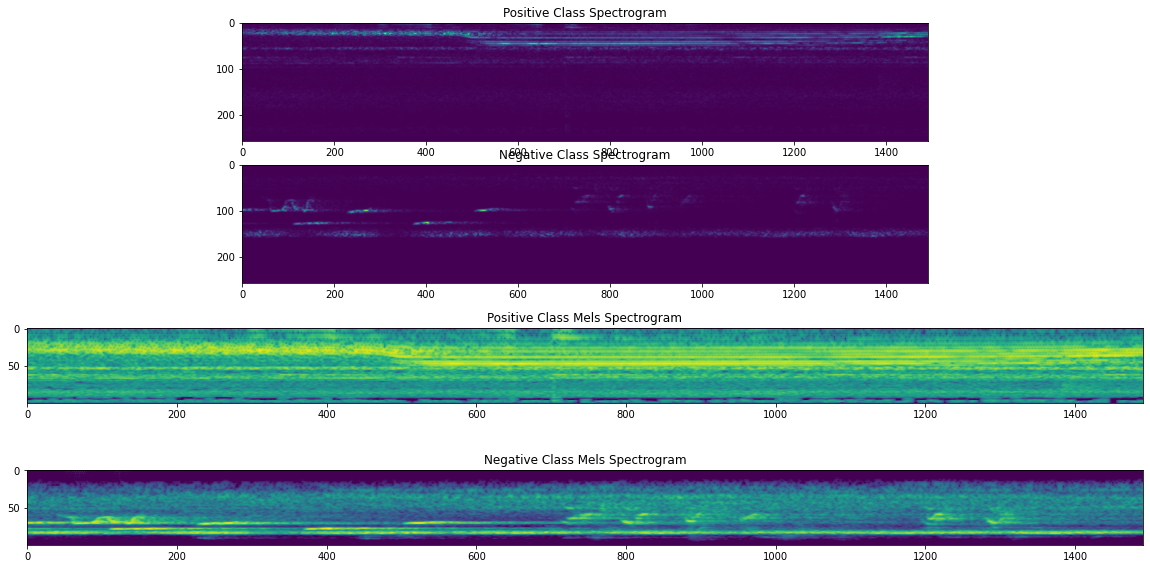

In [107]:
fig, axs = plt.subplots(nrows = 4, ncols = 1, figsize = (20,10))
axs[0].title.set_text('Positive Class Spectrogram')
axs[0].imshow(tf.transpose(spectrogram)[0])
axs[1].title.set_text('Negative Class Spectrogram')
axs[1].imshow(tf.transpose(spectrogram_neg)[0])
axs[2].title.set_text('Positive Class Mels Spectrogram')
axs[2].imshow(tf.transpose(log_mag_mel_spec)[0])
axs[3].title.set_text('Negative Class Mels Spectrogram')
axs[3].imshow(tf.transpose(log_mag_mel_spec_neg)[0])
plt.tight_layout



## Create a Training and Testing partition 

In [108]:
## This creates the data set
data = data.map(preprocess_to_mel_spectrogram)
data = data.cache()
data = data.shuffle(buffer_size = 1000)
data = data.batch(100)
data = data.prefetch(10)

In [109]:
##This splits the dataset into test/train
split = int(len(data)*0.7)+1

train = data.take(split)
test = data.skip(split).take(len(data)-split)

In [110]:
#Test 1 batch
samples, labels = train.as_numpy_iterator().next()
print(labels)

[0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 0. 1. 0.]


## Build a DL model 

In [111]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout

In [112]:
samples, labels = train.as_numpy_iterator().next()
print(labels)
input_shape = samples.shape[1:]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0.
 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 1. 0.]


In [113]:
#Build sequential model, compile it, and view summary
model = Sequential()
model.add(Conv2D(16, (3,3), activation = 'relu', input_shape = input_shape)) ##This is 16 kernels of shape 3x3, input shape 
model.add(Conv2D(16, (3,3), activation = 'relu')) ## as this is the Second layer, we no longer need an input shape - its connected directly to the prior layer
model.add(MaxPooling2D()),
model.add(Dropout(0.25)),
model.add(Flatten()) #This combines all the nodes from the previous conv2d layer into a single dimension
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [114]:
model.compile("Adam", 
            loss = 'BinaryCrossentropy',
            metrics = [tf.keras.metrics.Accuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [115]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1489, 98, 16)      160       
                                                                 
 conv2d_3 (Conv2D)           (None, 1487, 96, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 743, 48, 16)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 743, 48, 16)       0         
                                                                 
 flatten_1 (Flatten)         (None, 570624)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               73040000  
                                                      

## Train the model

In [116]:
hist = model.fit(train,
                 epochs = 15,
                 validation_data = test,
                 callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=4, restore_best_weights = True))

Epoch 1/15
7/7 [==============================] - 182s 26s/step - loss: 1069.2559 - accuracy: 0.6314 - recall_2: 0.0978 - precision_2: 0.2400 - val_loss: 476.7242 - val_accuracy: 0.2909 - val_recall_2: 1.0000 - val_precision_2: 0.2909
Epoch 2/15
7/7 [==============================] - 176s 26s/step - loss: 177.8421 - accuracy: 0.5614 - recall_2: 0.5255 - precision_2: 0.3411 - val_loss: 75.2230 - val_accuracy: 0.7727 - val_recall_2: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 3/15
7/7 [==============================] - 173s 25s/step - loss: 33.9296 - accuracy: 0.7386 - recall_2: 0.6354 - precision_2: 0.5951 - val_loss: 10.2735 - val_accuracy: 0.9182 - val_recall_2: 0.7097 - val_precision_2: 1.0000
Epoch 4/15
7/7 [==============================] - 173s 25s/step - loss: 4.7210 - accuracy: 0.9243 - recall_2: 0.7737 - precision_2: 1.0000 - val_loss: 1.0227 - val_accuracy: 0.9545 - val_recall_2: 0.9737 - val_precision_2: 1.0000
Epoch 5/15
7/7 [==============================] - 178s 26s/ste

In [117]:
print(hist)

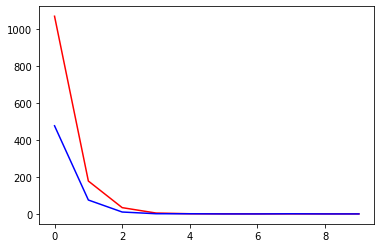

In [118]:
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()


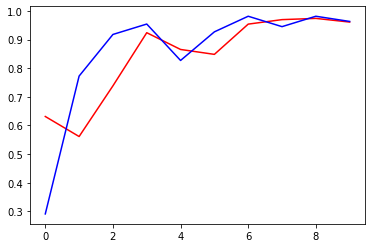

In [119]:
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()


In [120]:
plt.plot(hist.history['recall_1'], 'r')
plt.plot(hist.history['val_recall_1'], 'b')
plt.show()


KeyError: ignored

In [ ]:
plt.plot(hist.history['precision_1'], 'r')
plt.plot(hist.history['val_precision_1'], 'b')
plt.show()


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (10, 10))

ax1.title.set_text("Accuracy")
ax1.plot(hist.history['accuracy'], 'r')
ax1.plot(hist.history['val_accuracy'], 'b')
ax1.legend(['train', 'val'])

ax2.title.set_text("Loss")
ax2.plot(hist.history['loss'], 'r')
ax2.plot(hist.history['val_loss'], 'b')
ax2.set_ylim([0, 1])

ax3.title.set_text("Recall")
ax3.plot(hist.history['recall_1'], 'r')
ax3.plot(hist.history['val_recall_1'], 'b')

ax4.title.set_text("Precision")
ax4.plot(hist.history['precision_1'], 'r')
ax4.plot(hist.history['val_precision_1'], 'b')


## Make A prediction

In [121]:
X_test, y_test = test.as_numpy_iterator().next()

In [122]:
y_test.shape

(100,)

In [123]:
yhat = model.predict(X_test)

4/4 [==============================] - 16s 4s/step


In [124]:
yhat

array([[0.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [2.0776543e-37],
       [1.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [4.4762502e-25],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00],
       [6.3463675e-20],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.000000

#### Convert logits to classes

In [125]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [126]:
yhat

[0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0]

In [127]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=23>

In [128]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=23.0>

In [129]:
yhat

[0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0]

In [130]:
y_test

array([0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

In [131]:
from sklearn.metrics import confusion_matrix, classification_report

In [132]:
confusion_matrix(y_test, yhat)

array([[77,  0],
       [ 0, 23]])

In [133]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        77
         1.0       1.00      1.00      1.00        23

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [134]:
import seaborn as sns

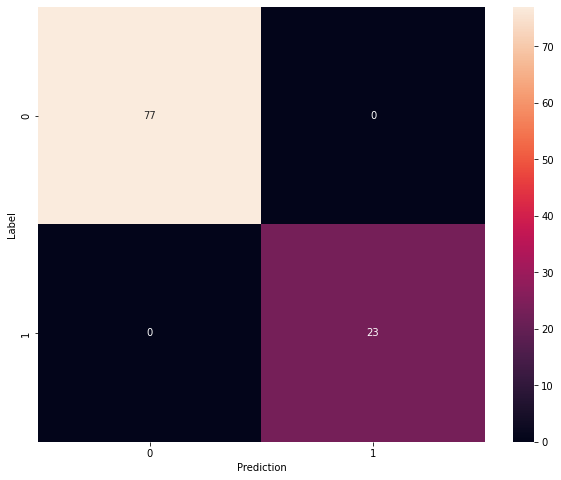

In [135]:
confusion_mtx = tf.math.confusion_matrix(y_test, yhat)
fig = plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=[0,1],
            yticklabels=[0,1],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
fig.savefig('cf')

In [136]:
def load_mp3_16k_mono(filename, sample_rate_out = 16000):
  """ Load a WAV file, convert it to a float tensor, resample
  to a 16 kHz single
  """
  res = tfio.audio.AudioIOTensor(filename)
  # Convert to tensor and combine channels
  tensor = res.to_tensor()
  tensor = tf.math.reduce_sum(tensor, axis = 1) / 2
  #extract sample rate and cast to tf.datatype
  sample_rate = res.rate
  sample_rate = tf.cast(sample_rate, dtype = tf.int64)
  # Resample to sample_rate_out
  wav = tfio.audio.resample(tensor, rate_in = sample_rate, rate_out = sample_rate_out)
  return wav

In [137]:
mp3 = '../data/Forest Recordings/recording_00.mp3' 

In [138]:
wav = load_mp3_16k_mono(mp3)

In [139]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length = 48000, sequence_stride = 48000, batch_size = 1)

In [140]:
sample, index = audio_slices.as_numpy_iterator().next()

In [141]:
sample[0].shape

(48000,)

In [142]:
def preprocess_to_mel_spectrogram_mp3(sample, label, frames = 48000):    
    ##Calculate the number of zeros for padding, note if the wav >= frames, this will be empty
    sample = sample[0]
    zero_padding = tf.zeros([frames] - tf.shape(sample), dtype = tf.float32)

    ##Add zeros at the start IF the wav length < frames
    wav = tf.concat([zero_padding, sample], 0)

    #use short time fourier transform
    spectrogram = tf.signal.stft(wav,
     frame_length = 320, ##This is fft_size
     frame_step = 32 ## this is hop_size
        ) #

    #Get the magnitude of the signal (los direction)
    spectrogram = tf.abs(spectrogram)
    
    mel_filter = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=100,
        num_spectrogram_bins = 257,
        sample_rate=frames,
        lower_edge_hertz=frames/100,
        upper_edge_hertz=frames/2,
        dtype=tf.dtypes.float32)

    mel_power_spectrogram = tf.matmul(tf.square(spectrogram), mel_filter)

    log_magnitude_mel_spectrograms = power_to_db(mel_power_spectrogram)

    log_magnitude_mel_spectrograms = tf.expand_dims(log_magnitude_mel_spectrograms, axis = 2)

    return log_magnitude_mel_spectrograms

In [143]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [144]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length = 48000, sequence_stride = 48000, batch_size = 1)
audio_slices = audio_slices.map(preprocess_to_mel_spectrogram_mp3)
audio_slices = audio_slices.batch(64)

In [145]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 [==============================] - 6s 6s/step


In [146]:
from itertools import groupby


In [147]:
results = {}
for file in os.listdir('../data/Forest Recordings/'):
    FILEPATH = os.path.join('../data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_to_mel_spectrogram_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 8s 8s/step


In [148]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0],
 'recording_08.mp3': [0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  1],
 'recording_09.mp3': [0,
  0,
  0,
  

In [149]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 5,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_14.mp3': 0,
 'recording_18.mp3': 2,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_26.mp3': 2,
 'recording_25.mp3': 0,
 'recording_24.mp3': 0,
 'recording_27.mp3': 0,
 'recording_28.mp3': 4,
 'recording_30.mp3': 3,
 'recording_31.mp3': 7,
 'recording_32.mp3': 2,
 'recording_35.mp3': 0,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_40.mp3': 6,
 'recording_41.mp3': 0,
 'recording_42.mp3': 0,
 'recording_44.mp3': 1,
 'recording_43.mp3': 5,
 'recording_45.mp3': 3,
 'recording_46.mp3': 4,
 'recording_47.mp3': 4,
 'recording_50.mp3': 0,
 'recording_51.mp3': 3,
 'recording_53.mp3': 0,
 'recording_52.mp3': 0,
 'recording_56.mp3': 4,
 'recording_54.mp3': 3,
 'recording_55.mp3': 0,
 'recording_57.mp3': 4,
 'recording_68.mp3': 1,
 'recording_69.

In [150]:
import csv


In [151]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])